In [1]:
import os
import numpy as np 
import rasterio 
import raster_tools as rt
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import binary_dilation
import cv2
import subprocess

In [1]:
temp = "temp/"
work_dir = "processed_raster/"
target_dir = work_dir + "CostMaps/"
full_image = "base_raster/israelOrtho_20.tif"
slope_fname ="/base_raster/slope.tif"

In [2]:
try:
    os.mkdir(temp)
except FileExistsError:
    pass

In [5]:
feature_rast_fname = work_dir + "micro_features_amax.tif"
terrain_rast_fname = work_dir + "macro_features_softmax.tif"
std_rast_fname = work_dir + "rast_std_bin3x3.tif"
path_raster_fname = work_dir +"allowedPaths.tif"

In [6]:
path_src,path_rast = rt.memmap(path_raster_fname)
feature_src,feature_rast = rt.memmap(feature_rast_fname)
slope_src, slope_rast = rt.memmap(slope_fname)

Filename: temp/4d0d8ba4-e62e-4424-ac5c-52759c319804
Filename: temp/9f40013a-17d6-4cb6-8eeb-7fcdf4ee6a73
Filename: temp/976b002d-fd02-4fe0-996e-c1cea6e2bc09


In [12]:
terrain_src, terrain_rast = rt.memmap(terrain_rast_fname)
terrain_rast = np.max(terrain_rast[1:],0)
terrain_rast = terrain_rast > 0.1

Filename: temp/370f10a4-4473-4a0c-aa53-72bcec42f935


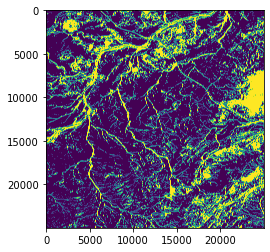

In [13]:
plt.imshow(terrain_rast)

In [8]:
classes_slope_rast = rt.intervalClassify(slope_rast,[i for i in range(5,25,5)]).astype(np.uint8)

In [9]:
nrows, ncols = feature_rast.shape

car_rast = rt.empty_memmap((nrows,ncols),np.uint8)
car_rast[:,:] = (feature_rast == 4)

asphalt_rast = rt.empty_memmap((nrows,ncols), np.uint8)
asphalt_rast[:,:] = (feature_rast == 1).astype(np.uint8)

costmap = rt.empty_memmap(slope_rast.shape,np.uint8)

Filename: temp/207ddfa3-b384-4e8e-817c-f37b28a53aff
Filename: temp/71ac2f40-fd58-4900-bf8e-d29cb80009cc
Filename: temp/ce4fde36-4f0d-4a28-bad1-90e9766eb515


In [10]:
i = 30
for v in np.unique(classes_slope_rast):
    if v <20:
        np.putmask(costmap, classes_slope_rast==v, i)
    else:
        np.putmask(costmap, classes_slope_rast==v, 255)
    i+=30

In [14]:
np.putmask(costmap,terrain_rast==1,190) # large rock formations
np.putmask(costmap,feature_rast ==2,210 ) # Bolders
np.putmask(costmap,feature_rast ==3,230 ) # Bush
np.putmask(costmap,feature_rast ==6,250 ) # water

In [15]:
np.putmask(costmap, path_rast ==1,0 ) # allowed paths
np.putmask(costmap, asphalt_rast ==1,170 ) # asphalt road paths

In [16]:
costmap_name = "costmap_MKII.tif"
profile = slope_src.profile
profile.update(dtype=np.uint8,count=1)
with rasterio.open(target_dir +costmap_name, "w+",**profile) as dst:
    dst.write(costmap.astype(np.uint8),1)

In [17]:
import subprocess
path = os.path.abspath(target_dir)
input_cm = costmap_name
output_cm =costmap_name.split(".")[0] + "_05.tif"
subprocess.run(f"gdal_translate -r nearest -tr 0.5 0.5 {input_cm} {output_cm}" ,shell=True,cwd= work_dir + "CostMaps")

CompletedProcess(args='gdal_translate -r nearest -tr 0.5 0.5 costmap_MKII.tif costmap_MKII_05.tif', returncode=0)

In [18]:
resampled_costmap = rasterio.open(target_dir +output_cm).read(1)
img = Image.fromarray(resampled_costmap)
img.save(target_dir +output_cm.split(".")[0] + ".pgm")

In [19]:
rasterio.open(target_dir +output_cm).bounds

BoundingBox(left=675697.6947, bottom=3383813.2641, right=680697.1947, top=3388812.7641)

# CostMap 2 ---> SLOPE ROUGHNESS

In [20]:
feature_rast_fname = work_dir + "features_argmax.tif"
terrain_rast_fname = work_dir + "terrain_smx_g.tif"
path_raster_fname = work_dir +"allowedPaths.tif"
full_image = "../BaseRaster/israelOrtho_20.tif"
slope_fname ="../BaseRaster/slope.tif"

In [21]:
src,rgb_rast =rt.readTiff(full_image)
rgb_rast = rgb_rast.astype(np.uint8)

In [22]:
edge_rast = rt.img2grayscale(rgb_rast)
edge_rast = rt.std_filter(edge_rast, ksize=5)

No Target
No Target


In [23]:
edge_rast =  cv2.blur(edge_rast, (31, 31))
edge_rast = cv2.GaussianBlur(
    edge_rast,
    (5,5),
    sigmaX=1.5,
    sigmaY=1.5,
    borderType=cv2.BORDER_DEFAULT)

1. asphalt
2. bolder
3. bush
4. cars
5. dirt road
6. water

In [24]:
feature_src, features = rt.readTiff(feature_rast_fname)
asphalt = features ==1
bolders = features ==2
bush = features ==3
cars = features ==4
dirt_road = features == 5
water = features ==6

In [25]:
terrain_src, terrain_rast = rt.readTiff(terrain_rast_fname)
terrain_rast = np.max(terrain_rast[1:], 0) > 0.2
path_src,path_rast = rt.readTiff(path_raster_fname)

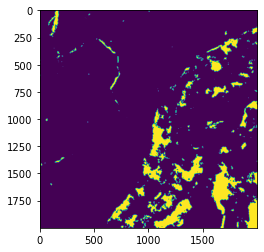

In [26]:
plt.imshow(terrain_rast[:2000,:2000])

In [27]:
slope_src, slope_rast = rt.readTiff(slope_fname)
slope_rast_lgr_20 = slope_rast > 20

In [28]:
terrain_rast.shape

(25000, 25000)

In [29]:
np.putmask(
    edge_rast,
    binary_dilation(cars,selem=np.ones((5,5))),
    edge_rast.mean())
edge_rast = rt.normalize(edge_rast)
slope_rast =rt.normalize(slope_rast)

In [30]:
edge_rast_02 = edge_rast > 0.2

In [31]:
slope_rast.shape

(25000, 25000)

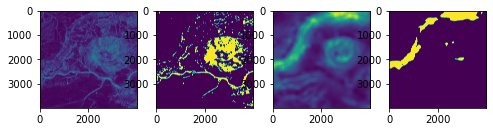

In [32]:

a = edge_rast[:4000,:4000]
b = edge_rast_02[:4000,:4000]
c = slope_rast[:4000,:4000]
d = slope_rast_lgr_20[:4000,:4000] 
fig, ax = plt.subplots(1,4, figsize=(8,4))
ax[0].imshow(a)
ax[1].imshow(b)
ax[2].imshow(c)
ax[3].imshow(d)

In [33]:
weights_roughness = 1
weights_slope = 1

In [34]:
slope_rast *= weights_slope
edge_rast *= weights_roughness

In [35]:
base_rast = slope_rast + edge_rast

In [36]:

np.putmask(base_rast,slope_rast_lgr_20, 0 )
np.putmask(base_rast,edge_rast_02, 0 )

In [37]:
base_rast = rt.normalize(base_rast, 95).astype(np.uint8)  + 20

In [38]:
np.putmask(base_rast, slope_rast_lgr_20, 255) # slope 1
np.putmask(base_rast, edge_rast_02, 255 -20) # edges 2
np.putmask(base_rast, asphalt, 255 -40) # edges 2
np.putmask(base_rast,water, 255 - 60 ) # water 3
np.putmask(base_rast,bush ==3, 255 - 80  ) # Bush 4
np.putmask(base_rast,bolders ==2, 255 -100 ) # Bolders 5
np.putmask(base_rast,terrain_rast==1, 255 -120) # large rock formations 6

In [39]:
weighted_paths = rt.normalize(path_rast * slope_rast, 19).astype(np.uint8)
base_rast[path_rast ==1] = weighted_paths[path_rast==1]

In [40]:
np.unique(base_rast)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 135, 195, 215,
       235, 255], dtype=uint8)

In [41]:
input_cm ="costmap_MKIII.tif"
profile = slope_src.profile
profile.update(dtype=np.uint8)
with rasterio.open(target_dir +input_cm,"w+",**profile) as dst:
    dst.write(base_rast,1)

In [42]:
import subprocess
path = os.path.abspath(target_dir)
output_cm =input_cm.split(".")[0] + "_05.tif"
subprocess.run(f"gdal_translate -r nearest -tr 0.5 0.5 {input_cm} {output_cm}" ,shell=True,cwd= work_dir + "CostMaps")

CompletedProcess(args='gdal_translate -r nearest -tr 0.5 0.5 costmap_MKIII.tif costmap_MKIII_05.tif', returncode=0)

In [43]:
resampled_costmap = rasterio.open(target_dir +output_cm).read(1)
img = Image.fromarray(resampled_costmap)
img.save(target_dir +output_cm.split(".")[0] + ".pgm")

In [44]:
rasterio.open(target_dir +output_cm).bounds

BoundingBox(left=675697.6947, bottom=3383813.2641, right=680697.1947, top=3388812.7641)